This file contains all of the code of ***validation_2ndorder*** and additionally has code to measure error and create the convergence plots.

In [2]:
import numpy as np

def A_matrix(n):
    A = np.zeros((n-1, n-1))
    for i in range(0, len(A)):
        for j in range(len(A[i])):
            if j == i - 1:
                A[i][j] = 1
            elif j == i:
                A[i][j] = -2
            elif j == i + 1:
                A[i][j] = 1
            else:
                A[i][j] = 0

    return A

In [3]:
import numpy as np

def u_exact(x, t, a, b, T):
    L = b-a
    u_e = np.sin(np.pi*x/L)*np.cos(np.pi*t/T)

    return u_e



def g_function(x, t, a, b, T, c_squared):
    af = 1
    bf = 1
    L = b-a

    g = np.sin(np.pi*x/L)*np.cos(np.pi*t/T)*(c_squared*af**2*np.pi**2/(L**2) - bf**2*np.pi**2/(T**2))

    return g


def ibvp_step(x, state, n, deltat, deltax, tk, a, b, A, I, c_squared, T):
    
    gt = g_function(x, tk, a, b, T, c_squared)
    
    gt1 = g_function(x, tk+deltat, a, b, T, c_squared)

    gt_concat = np.concatenate((np.zeros((n-1)), gt), axis=0)
    gt1_concat = np.concatenate((np.zeros((n-1)), gt1), axis=0)


    UL = np.zeros((n-1, n-1))
    UR = I
    LL = c_squared/(deltax**2)*A
    LR = np.zeros((n-1, n-1))

    temp1 = np.concatenate((UL,UR), axis=1)
    temp2 = np.concatenate((LL,LR), axis=1)
    f_matrix = np.concatenate((temp1,temp2), axis=0)
    I_concat = np.identity(2*n-2)

    LHS = I_concat - 1/2*deltat*f_matrix
    RHS = state + (1/2*deltat*((np.matmul(f_matrix, state)) + gt_concat + gt1_concat))

    state_updated = np.linalg.solve(LHS, RHS)
    
    return state_updated
    

def solve_ibvp(state_initial, deltat, deltax, T, a, b, c_squared):
    n = int(abs((b-a)/deltax))
    nt = int(abs(T/deltat))
    x = np.linspace(a+deltax, b-deltax, num=n-1)
    t = np.linspace(0, T, num=nt+1)
    A = A_matrix(n)
    I = np.identity(n-1)
    
    state_hat = [state_initial]
    for h in range(len(t)-1):
        state_updated = ibvp_step(x, state_hat[h], n, deltat, deltax, t[h], a, b, A, I, c_squared, T)
        state_hat.append(state_updated)
    
    state_hat = np.array(state_hat)

    return state_hat, x, t

In [4]:
import numpy as np

a = 0
b = 1
L = b-a
c_squared = 68.9e9 / 2710
deltat = 0.01
deltax = 0.001
T = 1
n = int(abs((b-a)/deltax))
nt = int(abs(T/deltat))
x = np.linspace(a+deltax, b-deltax, num=n-1)

ui = np.sin(np.pi*x/L)
vi = np.zeros((n-1))
initial_state = np.concatenate((ui, vi), axis=0)


state_hat, x, t = solve_ibvp(initial_state, deltat, deltax, T, a, b, c_squared)

In [5]:
print(state_hat)

[[ 3.14158749e-03  6.28314397e-03  9.42463843e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.14004247e-03  6.28005394e-03  9.42000344e-03 ... -9.26998681e-04
  -6.18004204e-04 -3.09003627e-04]
 [ 3.13538828e-03  6.27074561e-03  9.40604106e-03 ... -1.86547794e-03
  -1.24366219e-03 -6.21834162e-04]
 ...
 [-3.13538883e-03 -6.27074671e-03 -9.40604271e-03 ... -1.93524972e-03
  -1.29017709e-03 -6.45091733e-04]
 [-3.14004195e-03 -6.28005292e-03 -9.42000190e-03 ... -8.56588505e-04
  -5.71063708e-04 -2.85533256e-04]
 [-3.14158796e-03 -6.28314492e-03 -9.42463986e-03 ... -7.10036772e-05
  -4.73361668e-05 -2.36682070e-05]]


In [6]:
u_true = []

for d in range(len(t)):
    utk = u_exact(x, t[d], a, b, T)
    u_true.append(utk)

u_true = np.array(u_true)

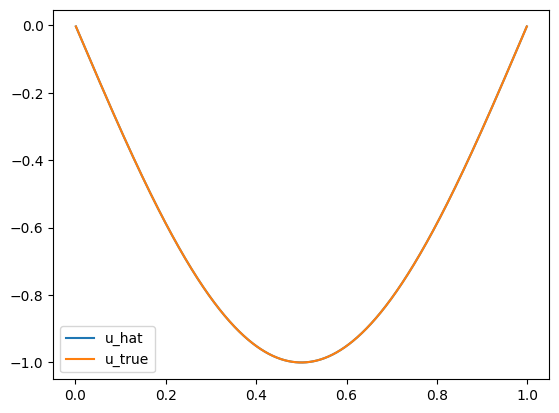

In [7]:
import matplotlib.pyplot as plt
import numpy as np

state_hat_split = np.hsplit(state_hat, 2)

plt.plot(x, state_hat_split[0][-1], label='u_hat')
plt.plot(x, u_true[-1], label='u_true')
plt.legend()
plt.show()

#print(uhat)

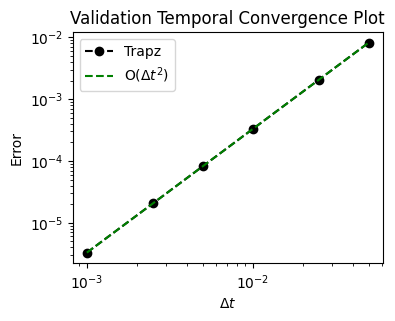

In [13]:
def temporal_error(state_initial, deltat, deltax, T, a, b, c_squared):
    u_delta_t, x_values, times = solve_ibvp(state_initial, deltat, deltax, T, a, b, c_squared)
    u_delta_t_split = np.hsplit(u_delta_t, 2)
    u_final_delta_t = u_delta_t_split[0][-1]
    err = (np.linalg.norm(u_final_delta_t - u_true[-1]))/(np.linalg.norm(u_true[-1]))
    return err

delta_ts = [0.001, 0.0025, 0.005, 0.01, 0.025, 0.05]
errors = []

for i in range(len(delta_ts)):
    error = temporal_error(initial_state, delta_ts[i], deltax, T, a, b, c_squared)
    errors.append(error)

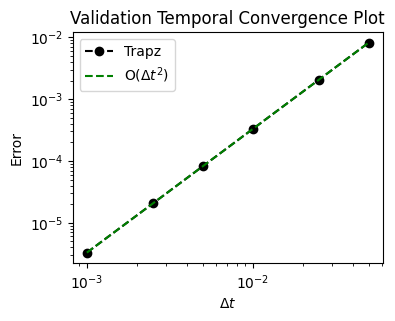

In [14]:
trapz_x = [delta_ts[0], delta_ts[-1]]
trapz_y = [errors[0], errors[0]*(delta_ts[-1]/delta_ts[0])**2]

fig_err = plt.figure(figsize=(4, 3))
err = fig_err.add_subplot(111)
err.plot(delta_ts, errors, 'ko--', label='Trapz')
err.plot(trapz_x, trapz_y, 'g--', label="O($\Delta$$t^2$)")
err.set_xlabel('$\Delta{}t$')
err.set_xscale('log')
err.set_ylabel('Error')
err.set_yscale('log')
err.set_title('Validation Temporal Convergence Plot')
err.legend()

In [14]:
def spatial_error(state_initials, deltat, deltax_s, T, a, b, c_squared):
    errors = []
    for i in range(len(deltax_s) - 1):

        state_i, x_values, times = solve_ibvp(state_initials[i], deltat, deltax_s[i], T, a, b, c_squared)
        state_i_split = np.hsplit(state_i, 2)
        u_i = state_i_split[0]
        x_i = u_i.T[int(1/(deltax_s[i]*2))]

        state_iplus1, x_values, times = solve_ibvp(state_initials[i+1], deltat, deltax_s[i+1], T, a, b, c_squared)
        state_iplus1_split = np.hsplit(state_iplus1, 2)
        u_iplus1 = state_iplus1_split[0]
        x_iplus1 = u_iplus1.T[int(1/(deltax_s[i+1]*2))]

        errors.append((np.linalg.norm(x_i - x_iplus1))/((np.linalg.norm(x_iplus1))))
    return errors

[0.007878027483252293, 0.0022022090102424593, 0.00031455150444247183, 7.86337014861103e-05, 2.20170970033065e-05, 3.145296013840597e-06]


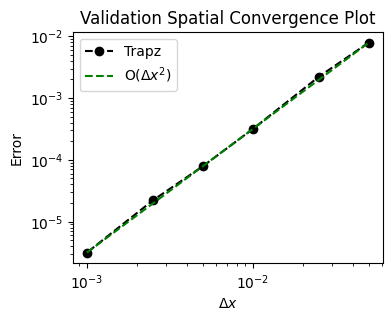

In [22]:
deltax_s = [0.05, 0.025, 0.01, 0.005, 0.0025, 0.001, 0.0005]
deltat = 0.001
initial_states = []
for i in range(len(deltax_s)):

    n = int(abs((b-a)/deltax_s[i]))
    x = np.linspace(a+deltax_s[i], b-deltax_s[i], num=n-1)

    ui = np.sin(np.pi*x/L)
    vi = np.zeros((n-1))
    initial_state = np.concatenate((ui, vi), axis=0)
    initial_states.append(initial_state)

errors = spatial_error(initial_states, deltat, deltax_s, T, a, b, c_squared)
print(errors)
trapz_x = [deltax_s[-2], deltax_s[0]]
trapz_y = [errors[-1], errors[-1]*(deltax_s[0]/deltax_s[-2])**2]

fig_err = plt.figure(figsize=(4, 3))
err = fig_err.add_subplot(111)
err.plot(deltax_s[0:-1], errors, 'ko--', label='Trapz')
err.plot(trapz_x, trapz_y, 'g--', label="O($\Delta$$x^2$)")
err.set_xlabel('$\Delta{}x$')
err.set_xscale('log')
err.set_ylabel('Error')
err.set_yscale('log')
err.set_title('Validation Spatial Convergence Plot')
err.legend()

In [8]:
# def spatial_error(state_initials, deltat, deltax_s, T, a, b, c_squared):
#     errors = []
#     for i in range(len(deltax_s) - 1):

#         state_i, x_values, times = solve_ibvp(state_initials[i], deltat, deltax_s[i], T, a, b, c_squared)
#         state_i_split = np.hsplit(state_i, 2)
#         u_i = state_i_split[0]
#         x_i = u_i.T[int(1/(deltax_s[i]*2))]
#         print(len(x_values))
#         u_true_x = []
#         for d in range(len(x_values)):
#             uxk = u_exact(x[d], t, a, b, T)
#             u_true_x.append(uxk)

#         u_true_x = np.array(u_true_x)

#         errors.append((np.linalg.norm(x_i - u_true_x[int(1/(deltax_s[i]*2))]))/((np.linalg.norm(u_true_x[int(1/(deltax_s[i]*2))]))))
#     return errors

In [18]:
# deltax_s = [0.005, 0.0025, 0.001, 0.0005]
# deltat = 0.01
# initial_states = []
# for i in range(len(deltax_s)):

#     n = int(abs((b-a)/deltax_s[i]))
#     x = np.linspace(a+deltax_s[i], b-deltax_s[i], num=n-1)

#     ui = np.sin(np.pi*x/L)
#     vi = np.zeros((n-1))
#     initial_state = np.concatenate((ui, vi), axis=0)
#     initial_states.append(initial_state)

# errors = spatial_error(initial_states, deltat, deltax_s, T, a, b, c_squared)
# print(errors)
# trapz_x = [deltax_s[-2], deltax_s[0]]
# trapz_y = [errors[-1], errors[-1]*(deltax_s[0]/deltax_s[-2])**2]

# fig_err = plt.figure(figsize=(4, 3))
# err = fig_err.add_subplot(111)
# err.plot(deltax_s[0:-1], errors, 'ko--', label='Trapz')
# err.plot(trapz_x, trapz_y, 'g--', label="O($\Delta$$x^2$)")
# err.set_xlabel('$\Delta{}x$')
# err.set_xscale('log')
# err.set_ylabel('Error')
# err.set_yscale('log')
# err.set_title('Validation Spatial Convergence Plot')
# err.legend()